<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Lab4%5Cmy_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None)

In [5]:
print(df.shape)
df_jester = df.copy()
df_jester = df_jester.drop(df_jester.columns[0],axis=1)
arr = df_jester.values

(24983, 101)


In [17]:
df_jester = df_jester.replace(99,np.nan)
avg_list = df_jester.mean(axis=0)
print(avg_list.idxmax(),avg_list.idxmin())
print(avg_list.max(),avg_list.min())
df_jester.loc[11290,7]

50 58
3.6650848950824937 -3.8338796373689923


-2.57

In [ ]:
rated = np.where(arr!=99)

def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(arr!=99)
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

new_arr, idx = replace(arr, 0.1)

# arr = arr.replace(99,np.nan)
# arr = arr.drop(arr.columns[0],axis=1)
data = pd.DataFrame(new_arr)
data = data.replace(99,np.nan)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,NaN,-7.43,-9.81,-9.85,-9.85,NaN,1.50,-4.37,-9.81,NaN,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,NaN,7.82,5.05,4.95,NaN,-8.40,-8.40,-8.40,...,8.59,3.59,NaN,NaN,2.82,-1.36,-9.08,8.30,5.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,NaN,6.75,8.64,NaN,NaN,NaN,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,NaN,NaN,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,NaN,NaN,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,NaN,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,NaN,-0.19,-2.14,NaN,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,NaN,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,NaN,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,NaN,NaN,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,NaN,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,NaN,7.23,-2.33,-9.66,2.72,-1.36,NaN,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,NaN,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,NaN,9.08,2.33,3.20,6.75,-8.79,NaN,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,NaN,5.63,NaN,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,4.42,...,8.59,NaN,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,NaN,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,NaN,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,NaN,9.08,8.93,3.74,3.20,-9.17,-8.98,8.79,-7.67,-3.06,NaN,8.40,-0.63,NaN,0.58,8.88,9.27,8.50,...,2.77,8.11,-7.96,NaN,-0.87,-5.87,8.88,-1.12,-8.74,8.74,NaN,NaN,NaN,NaN,NaN,4.90,NaN,NaN,NaN,NaN,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,-0.87,-1.36,-0.58,-1.17,-5.73,NaN,0.24,9.22,NaN,-7.23,-8.59,9.13,NaN
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,NaN,NaN,-6.46,-1.65,-6.80,-6.41,-6.99,7.23,NaN,-6.99,6.55,NaN,NaN,NaN,NaN,0.49,-0.53,-6.94,-0.49,NaN,6.46,-0.53,NaN,NaN,-7.86,NaN,NaN,-6.94,NaN,NaN,...,0.49,-0.24,NaN,NaN,-3.11,-6.65,NaN,-0.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,NaN,NaN,NaN,NaN,NaN,-9.47,NaN,3.45,-0.92,-4.51,-4.13,-5.73,-9.51,2.82,NaN,NaN,NaN,NaN,NaN,2.91,2.62,8.30,NaN,3.06,5.44,NaN,NaN,-0.68,2.04,NaN,NaN,1.55,NaN,...,NaN,-0.78,NaN,NaN,NaN,-2.48,NaN,1.26,5.78,NaN,NaN,NaN,NaN,NaN,-4.

In [ ]:
n_latent_factors = 4

user_ratings = data.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [ ]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [ ]:
num_iter = 30000

In [ ]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[-2.421, -2.026, -4.575, ..., -2.758, -7.829, -2.587],
       [ 1.839,  3.591,  3.971, ...,  4.587,  3.376,  5.173],
       [ 7.626,  7.139,  7.699, ...,  6.468,  7.301,  7.395],
       ...,
       [-2.874, -1.513, -2.356, ...,  0.533, -3.009,  0.576],
       [-0.357,  0.51 , -1.393, ..., -0.785, -4.739, -0.338],
       [ 1.444,  1.325,  1.79 , ...,  4.454,  3.526,  4.622]])

In [ ]:
values = [zip(user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
hist = sgd(num_iter)

Iteration 0/300:	MSE=25.750515
Iteration 10/300:	MSE=23.947930
Iteration 20/300:	MSE=21.884641
Iteration 30/300:	MSE=18.050646
Iteration 40/300:	MSE=17.396328
Iteration 50/300:	MSE=17.196769
Iteration 60/300:	MSE=17.027322
Iteration 70/300:	MSE=16.813699
Iteration 80/300:	MSE=16.569119
Iteration 90/300:	MSE=16.320876
Iteration 100/300:	MSE=16.059612
Iteration 110/300:	MSE=15.806479
Iteration 120/300:	MSE=15.606152
Iteration 130/300:	MSE=15.467857
Iteration 140/300:	MSE=15.374995
Iteration 150/300:	MSE=15.312121
Iteration 160/300:	MSE=15.269560
Iteration 170/300:	MSE=15.241011
Iteration 180/300:	MSE=15.222034
Iteration 190/300:	MSE=15.209487
Iteration 200/300:	MSE=15.201214
Iteration 210/300:	MSE=15.195780
Iteration 220/300:	MSE=15.192244
Iteration 230/300:	MSE=15.189993
Iteration 240/300:	MSE=15.188624
Iteration 250/300:	MSE=15.187873
Iteration 260/300:	MSE=15.187560
Iteration 270/300:	MSE=15.187564
Iteration 280/300:	MSE=15.187803
Iteration 290/300:	MSE=15.188219


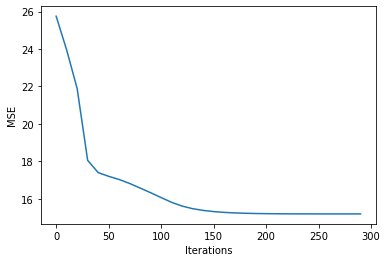

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,"(-7.82, 1.0189010853963956)","(8.79, 1.4393804418822886)","(-9.66, 1.2201808547777007)","(-8.16, 1.4744140088643207)","(-7.52, 1.5065962669032116)","(-8.5, 1.0767438717966158)","(-9.85, 0.5469287711082024)","(4.17, 0.8192953728858393)","(-8.98, 1.6200597686905096)","(-4.76, 1.6842375774532814)","(-8.5, 1.2854452615766452)","(-6.75, 0.6482400481545848)","(-7.18, 1.3473548343968687)","(8.45, 1.1831770668640587)","(-7.18, 0.8746460909261861)","(nan, 1.163621367704273)","(-7.43, 0.4953717355807697)","(-9.81, 1.478856166417718)","(-9.85, 1.8120077525195069)","(-9.85, 0.8679846916808626)","(nan, 0.4914385347304964)","(1.5, 1.2668777003764156)","(-4.37, 1.0794616075682548)","(-9.81, 0.751945083952767)","(nan, 1.5980449470532117)","(1.12, 1.5160719771400597)","(7.82, 1.6670110897629282)","(2.86, 1.2209806962870322)","(9.13, 1.0779027439381783)","(-7.43, 2.0097068754780976)","(2.14, 1.4250083093099095)","(-4.08, 1.0490092676884701)","(nan, 1.5745740387316056)","(7.82, 0.654897788442549)","(5.05, 1.6393429215036932)","(4.95, 1.3399211692540924)","(nan, 1.6094460719106176)","(-8.4, 1.192203805305938)","(-8.4, 1.6318821487536457)","(-8.4, 1.32733365436097)",...,"(8.59, 0.7598299834323932)","(3.59, 1.652696485346577)","(nan, 1.7307781553105301)","(nan, 1.673072019141465)","(2.82, 0.8595184017079963)","(-1.36, 1.9707101306749117)","(-9.08, 0.706117183600305)","(8.3, 1.038278265228182)","(5.68, 0.5246259808484582)","(nan, 1.3836027364106074)","(nan, 1.0853075824985958)","(nan, 0.5857766156879217)","(nan, 1.5161992510964848)","(nan, 0.4870775485466341)","(nan, 1.286245450132942)","(nan, 1.0814273268262529)","(nan, 1.2638818771923612)","(-9.42, 0.9245968537235327)","(nan, 1.3171276798798999)","(nan, 1.3294961195145127)","(nan, 1.1964599612065283)","(-7.72, 1.3718292128199052)","(nan, 0.8847415444332807)","(nan, 0.9128408673312106)","(nan, 1.234047294660305)","(nan, 1.6917861673580648)","(nan, 1.718236895344715)","(nan, 1.0211619349571137)","(nan, 0.9282362258661935)","(nan, 0.3719716845025885)","(2.82, 1.2801725963158663)","(nan, 0.7810339183620509)","(nan, 1.2440817061314124)","(nan, 1.0627583430932275)","(nan, 0.49240083872642193)","(nan, 0.7561575783508379)","(-5.63, 0.8169343467822834)","(nan, 1.29856609243366)","(nan, 0.7754301017702522)","(nan, 0.9781363379986855)"
1,"(4.08, 0.7715596505779951)","(-0.29, 1.3875076297639068)","(6.36, 1.0024342854638453)","(4.37, 1.8553250145255256)","(-2.38, 2.0123204827345287)","(-9.66, 1.4960394363404532)","(-0.73, 0.7407822481686951)","(-5.34, 0.9530415446902483)","(8.88, 1.93637435204829)","(nan, 2.1471243106654323)","(6.75, 1.5504926471730378)","(8.64, 1.061480011104309)","(nan, 1.3813042550108467)","(nan, 1.4159175428329347)","(nan, 0.8556691359996405)","(-0.97, 1.2688196500378675)","(4.66, 0.63307438295548)","(-0.68, 1.6845482774670844)","(3.3, 1.9323338563242434)","(-1.21, 1.470811130503899)","(0.87, 0.4492738171365722)","(8.64, 1.1673957626969)","(8.35, 1.1578520583191763)","(9.17, 1.0081190470218169)","(0.05, 1.8416312565683002)","(7.57, 1.9031659574036235)","(4.71, 1.6462828214207705)","(0.87, 1.7062251686860217)","(-0.39, 1.3185343779512706)","(6.99, 2.514777220627455)","(6.5, 1.3830465157368008)","(nan, 1.412406659711937)","(nan, 2.042437398533398)","(9.03, 0.8613628873251498)","(-1.8, 2.2683094056403887)","(0.73, 1.6015372794241751)","(7.09, 1.9328331216509766)","(3.4, 1.5428800211055975)","(-0.87, 1.7637341989075344)","(7.91, 1.5715263243675586)",...,"(-6.7, 0.9040797130857864)","(nan, 1.6849814179699631)","(nan, 1.9132029177585412)","(4.47, 1.9473082408750977)","(4.08, 1.2667162859975336)","(-3.83, 2.3503909751322025)","(8.74, 1.0235034403588075)","(1.12, 0.916603157581523)","(0.78, 0.9799180158481571)","(7.52, 1.7351872577435887)","(-5.0, 1.29963966308877

In [ ]:
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()
comparison_data.columns = data.columns
comparison_data